In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def AofT(time,T, ai, taui):
    return ai*np.exp(-time/taui)/(1.+np.exp(-T/(2*taui)))

In [3]:
from SimPEG import *
from simpegem1d.Waveform import CausalConv
import sys
sys.path.append("./DoubleLog/")
from plotting import mapDat

In [4]:
class LinearSurvey(Survey.BaseSurvey):
    nD = None
    def __init__(self, time, **kwargs): 
        self.time = time
        self.nD = time.size
        
    def projectFields(self, u):
        return u

class LinearProblem(Problem.BaseProblem):

    surveyPair = LinearSurvey

    def __init__(self, mesh, G, **kwargs):
        Problem.BaseProblem.__init__(self, mesh, **kwargs)
        self.G = G

    def fields(self, m, u=None):
        return self.G.dot(m)

    def Jvec(self, m, v, u=None):
        return self.G.dot(v)

    def Jtvec(self, m, v, u=None):
        return self.G.T.dot(v)


# Simple exponential basis


$$ \mathbf{A}\mathbf{\alpha} = \mathbf{d}$$

In [5]:
tind = 12
time = np.load('./exampledata/timevtem.npy')[4:]
obs = np.load('./exampledata/souding.npy')[4:]
wave = np.loadtxt('/Users/sgkang/Dropbox/Shared/SeogiDikun/Milligan/Data/7042_106_wform.xyz', skiprows=7)
M = 81
tau = np.logspace(-5, -2, M)

In [6]:
twave = (np.arange(10000)+1)*1e-5
indstart = 4439
indend = 6000
t0_wave = twave[indstart:indend].min()
time_conv= twave[indstart:indend]-t0_wave

In [7]:
currentderiv = wave[indstart:indend]
currentderiv[time_conv>4.4e-3] = 0.
current = CausalConv(wave[indstart:indend], np.ones_like(wave[indstart:indend]), time_conv)

(-4.5, 4.5)

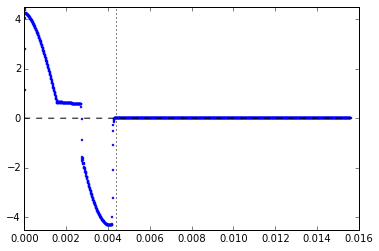

In [8]:
# figsize(6, 4)

plt.plot(time_conv, wave[indstart:indend], 'b.', lw=2, ms=4)
plt.plot(time_conv, wave[indstart:indend]*0., 'k--')
plt.plot(np.r_[4.4000000e-03, 4.4000000e-03], np.r_[-4.5, 4.5], 'k:')
plt.ylim(-4.5, 4.5)
# plt.xlim(-2e-4, 5.5e-3)

In [9]:
current.min()

3.0000000000009182e-09

(0, 1.0)

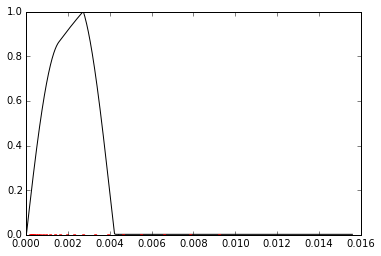

In [10]:
figsize(6, 4)
plt.plot(time_conv, current/current.max(), 'k-')
# plt.plot(time_conv, wave[indstart:indend]*0., 'k--')
plt.plot(np.r_[4.4000000e-03, 4.4000000e-03], np.r_[1e-6, 1e-2], 'k:')
plt.plot(time, np.zeros_like(time), 'r.')
plt.ylim(0, 1.)

In [11]:
from SimPEG import Mesh
from simpegem1d.Waveform import SineFun, SineFunDeriv, CausalConv
dt = 1e-5
t0 = 4.4000000e-03
ntime = time_conv.size
meshtime = Mesh.TensorMesh([dt*np.ones(ntime)], x0=[-dt/2.])
P = meshtime.getInterpolationMat(time+t0, 'CC')
# time_conv = meshtime.gridN
# currentderiv = SineFunDeriv(time_conv, t0)
# current = SineFun(time_conv, t0)

In [12]:
temp = np.exp(-time_conv/1e-2)/1e-2
out = CausalConv(temp, currentderiv, time_conv)
# plt.plot(time_conv, currentderiv)

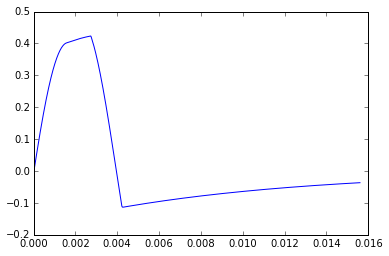

In [13]:
plt.plot(time_conv, out)

In [14]:
time_conv.min(), time_conv.max()

(0.0, 0.015600000000000003)

In [15]:
P.shape

(23, 1561)

In [16]:
N = time.size
A = np.zeros((N, M))
for j in range(M):
    A[:,j] = P*(CausalConv(1./tau[j]*np.exp(-time_conv/tau[j]), -currentderiv, time_conv))

In [17]:
mtrue = np.zeros(M)

In [18]:
np.random.seed(1)
inds = np.random.random_integers(0, 41, size=5)
mtrue[inds] = np.r_[0.1, 2, 1, 4, 5]

In [19]:
out = np.dot(A,mtrue)

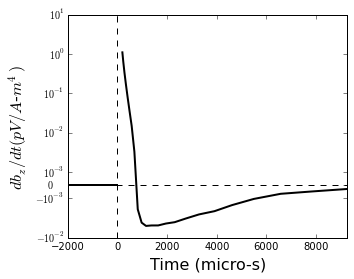

In [20]:
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)

# for i, ind in enumerate(inds):
#     temp, dum, dum = mapDat(mtrue[inds][i]*np.exp(-time/tau[ind]), 1e-5, stretch=2)
#     plt.semilogx(time, temp, 'k', alpha = 0.5)    
outmap, ticks, tickLabels = mapDat(obs,1e-3, stretch=3)    
ax.plot(time*1e6, outmap, 'k', lw=2)
ax.plot(np.r_[-0.002, 0.]*1e6, np.zeros(2), 'k', lw=2)
ax.plot(np.zeros(2), np.r_[ticks.min(), ticks.max()], 'k--', lw=1)
ax.set_yticks(ticks)
ax.set_yticklabels(tickLabels)
ax.set_ylim(ticks.min(), ticks.max())
ax.plot(np.r_[-0.002, time.max()]*1e6, np.zeros(2), 'k--')
ax.set_xlim(-0.002*1e6, time.max()*1e6)

ax.set_xlabel("Time (micro-s)", fontsize = 16)
ax.set_ylabel("$db_z/dt (pV/A$-$m^4)$ ", fontsize = 16)

# ax.grid(True)

In [21]:
# from pymatsolver import MumpsSolver

In [22]:
ip = obs[obs<0.]
print obs[obs>0.]/abs(ip).max()

[ 220.51422846  128.           68.43166333   34.49238477   16.54749499
    7.3507014     2.98677355    0.66312625]


In [23]:
from SimPEG import Maps

In [24]:
weight = np.sqrt(np.diag(np.dot(A.T, A)))

In [66]:
mesh = Mesh.TensorMesh([M])
wmap = Maps.Weighting(mesh, weights=weight)
prob = LinearProblem(mesh, A)
survey = LinearSurvey(time)
survey.pair(prob)
# survey.makeSyntheticData(mtrue, std=0.01)
# survey.dobs = out
survey.dobs = obs
reg = Regularization.BaseRegularization(mesh, mapping=wmap)
dmis = DataMisfit.l2_DataMisfit(survey)
# uncert = 0.01*(abs(survey.dobs)+abs(ip).max())
uncert = 0.05*(abs(survey.dobs)+abs(ip).max())
# uncert = 0.05*(abs(survey.dobs))
dmis.Wd = 1./(uncert)
opt = Optimization.ProjectedGNCG(maxIter=10)
# opt = Optimization.InexactGaussNewton(maxIter=20)
opt.lower = -1e-10
# opt.upper = 1e-10
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 1e-5
beta = Directives.BetaSchedule()
beta.coolingFactor = 1
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, target])
m0 = np.zeros(M)
opt.tolG = 1e-10
opt.tolG = 1e-10
reg.mref = np.zeros_like(M)
mrec = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.00e-05  4.77e+02  0.00e+00  4.77e+02    2.15e+04      0              
   1  1.00e-05  1.09e+02  2.56e-02  1.09e+02    1.95e+00      0              
   2  1.00e-05  2.85e+01  2.40e-02  2.85e+01    2.39e+00      0              
   3  1.00e-05  1.31e+01  3.74e-02  1.31e+01    2.61e+00      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.7844e+01
0 : |xc-x_last| = 5.6902e+05 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 2.8102e+00 <= tolG          = 1.0000e-10
0 : |proj(x-g)-x|    = 2.8102e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =  

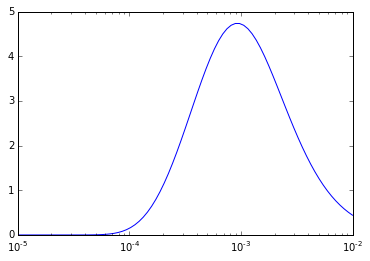

In [67]:
plt.semilogx(tau, weight)

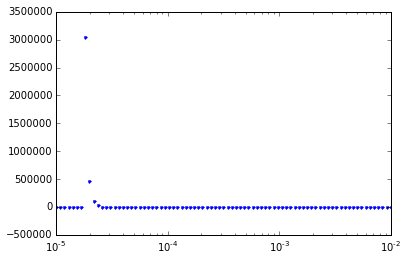

In [68]:
plt.semilogx(tau, mrec, '.')

In [69]:
mfund = mrec.copy()
mip = mrec.copy()
mfund[mfund<0.] = 0.
mip[mip>0.] = 0.
fund = np.dot(A, mfund)

In [70]:
ip = obs-invProb.dpred

In [71]:
tind = 7
print obs[tind], invProb.dpred[tind], ip[tind]

0.003309 0.0106818657748 -0.0073728657748


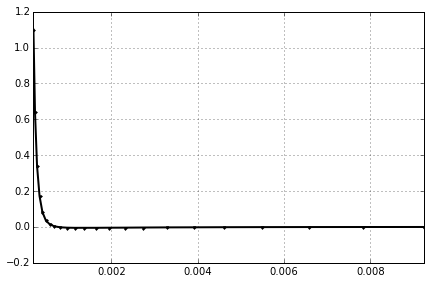

In [72]:
fig = plt.figure(figsize=(7,4.5))
ax = plt.subplot(111)
ax.plot(time, obs, 'k.-', lw=2)
# ax.set_ylim(1e-4, 1e0)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlim(time.min(), time.max())
ax.grid(True)

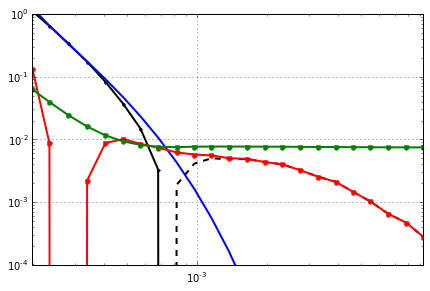

In [73]:
fig = plt.figure(figsize=(7,4.5))
ax = plt.subplot(111)
ax.plot(time, obs, 'k.-', lw=2)
ax.plot(time, -obs, 'k--', lw=2)
ax.plot(time, invProb.dpred, 'b-', lw=2)
ax.plot(time, -ip, 'r.-', lw=2, ms=10)
ax.plot(time, uncert, 'g.-', lw=2, ms=10)
ax.set_ylim(1e-4, 1e0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(time.min(), time.max())
ax.grid(True)

In [74]:
predmap, ticks, tickLabels = mapDat(invProb.dpred,1e-3, stretch=3)    

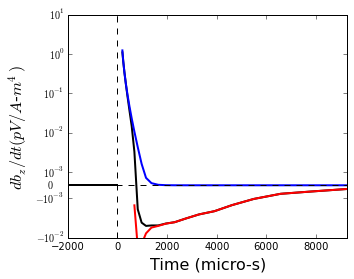

In [75]:
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)

# for i, ind in enumerate(inds):
#     temp, dum, dum = mapDat(mtrue[inds][i]*np.exp(-time/tau[ind]), 1e-5, stretch=2)
#     plt.semilogx(time, temp, 'k', alpha = 0.5)    
outmap, ticks, tickLabels = mapDat(obs,1e-3, stretch=3)    
ax.plot(time*1e6, outmap, 'k', lw=2)
ax.plot(time*1e6, predmap, 'b', lw=2)
ax.plot(time[7:]*1e6, outmap[7:]-predmap[7:], 'r', lw=2)
ax.plot(np.r_[-0.002, 0.]*1e6, np.zeros(2), 'k', lw=2)
ax.plot(np.zeros(2), np.r_[ticks.min(), ticks.max()], 'k--', lw=1)
ax.set_yticks(ticks)
ax.set_yticklabels(tickLabels)
ax.set_ylim(ticks.min(), ticks.max())
ax.plot(np.r_[-0.002, time.max()]*1e6, np.zeros(2), 'k--')
ax.set_xlim(-0.002*1e6, time.max()*1e6)

ax.set_xlabel("Time (micro-s)", fontsize = 16)
ax.set_ylabel("$db_z/dt (pV/A$-$m^4)$ ", fontsize = 16)

# ax.grid(True)

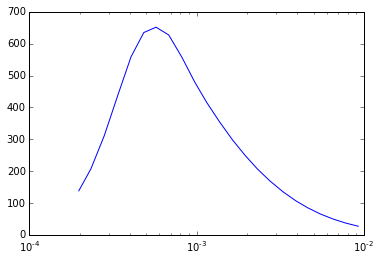

In [76]:
weight_d = np.sqrt(np.diag(np.dot(np.dot(np.diag(1./uncert), A), (np.dot(np.diag(1./uncert), A)).T)))
# weight_d = np.sqrt(np.diag( np.dot(A, A.T)))
plt.semilogx(time, weight_d)